# Fe test

In [22]:
import sys
sys.path.append('..')

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read
from asap3 import FullNeighborList

from m_ff.configurations import carve_confs

from m_ff.kernels import TwoBodySingleSpeciesKernel, ThreeBodySingleSpeciesKernel
from m_ff.gp import GaussianProcess, TwoBodySingleSpeciesGP, ThreeBodySingleSpeciesGP
from m_ff.grid import SingleSpeciesGrid

from m_ff.interpolation import Spline3D, Spline1D
from m_ff.calculators import ThreeBodySingleSpecies

logging.basicConfig(level=logging.INFO)

## Parameters

In [48]:
# Parameters
directory = Path('data/Fe_vac/')
r_cut = 3.0
sigma_2b = 0.3
sigma_3b = 0.6
noise = 0.0001

# GP Parameters
ntr = 2
ntest = 2
combine_2b_3b = True

# mapping
grid_start = 1.5
elementslist = [26]
num_2b = 100
num_3b = 10


## Configurations

In [49]:
# # # ----------------------------------------
# # # Construct a configuration database
# # # ----------------------------------------


# n_data = 50

# filename = directory / 'movie.xyz'

# traj = read(filename, index=slice(None), format='extxyz')

# elements, confs, forces, energies = carve_confs(
#     traj, r_cut, n_data,
#     forces_label='force', energy_label='energy')

# if not os.path.exists(directory):
#     os.makedirs(directory)

# np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
# np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
# np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

# lens = [len(conf) for conf in confs]

# logging.info('\n'.join((
#     'Number of atoms in a configuration:',
#     '   maximum: {}'.format(np.max(lens)),
#     '   minimum: {}'.format(np.min(lens)),
#     '   average: {:.4}'.format(np.mean(lens))
# )))

## GP

In [50]:
# ----------------------------------------
# Test a simple GP on the built database
# ----------------------------------------


# Get configurations and forces from file
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
# tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
# tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]

In [51]:
theta_2b = [sigma_2b, r_cut / 10.0, r_cut]
theta_3b = [sigma_3b, r_cut / 10.0, r_cut]


two_body_train_forces = np.zeros((ntr, 3))

if combine_2b_3b:
    
    # First train with a 2 body
    gp_2 = TwoBodySingleSpeciesGP(theta_2b, noise=noise)

    print('Training 2B GP')
    gp_2.fit(tr_confs, tr_forces)

    gp_2_name = 'gp_ker=2_ntr={}_sig={:.2f}_cut={:.2f}'.format(
        ntr, sigma_2b, r_cut)
    gp_2.save(directory / gp_2_name)

    # Calculate the predictions of the 2body on the training set
    for i in np.arange(ntr):
        two_body_train_forces[i] = gp_2.predict(
            np.reshape(tr_confs[i], (1, len(tr_confs[i]), 5)))


# Then train with a 2 body on the difference between tr_force and tr_force obtained with the two body
gp_3 = ThreeBodySingleSpeciesGP(theta_3b, noise=noise, optimizer=None)

print('Training 3B GP')
gp_3.fit(tr_confs, tr_forces - two_body_train_forces)

gp_3_name = 'gp_ker=3_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma_3b, r_cut)
gp_3.save(directory / gp_3_name)

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels
INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body single species kernels


Training 2B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=2_ntr=2_sig=0.30_cut=3.00


INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body single species kernels


Training 3B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=3_ntr=2_sig=0.60_cut=3.00


In [52]:
# Test the GP performance
print('Testing GP')

gp_3b_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))
gp_2b_error = np.zeros((ntest, 3))
gp_2b_forces = np.zeros((ntest, 3))

for i in np.arange(ntest):
    if combine_2b_3b:
        gp_2b_forces[i, :] = gp_2.predict(np.reshape(
            tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_2b_error[i, :] = gp_2b_forces[i, :] - tst_forces[i, :]
    gp_3b_forces[i, :] = gp_3.predict(np.reshape(
        tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_2b_forces[i, :] + gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MAEF_2B = np.mean(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))
SMAE_2B = np.std(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('2 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF_2B, SMAE_2B))
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print(
    'Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
2 body MAEF on forces: 0.6792 +- 0.2499
MAEF on forces: 0.6736 +- 0.2497
Relative MAEF on forces: 0.7608 +- 0.2820


## Mapping

In [53]:
# ----------------------------------------
# Mapping
# ----------------------------------------

mapping_2b = SingleSpeciesGrid(gp_2, grid_start, r_cut, num_2b, elementslist[0], build2donly=True)
all_grids_2b = mapping_2b.build_grids()

remap_name_2b = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}.npy'.format(
    2, ntr, sigma_2b, r_cut)

np.save(directory / remap_name_2b, all_grids_2b)
print('Saved mapping with name {}'.format(remap_name_2b))

Saved mapping with name MFF_2b_ntr_2_sig_0.30_cut_3.00.npy


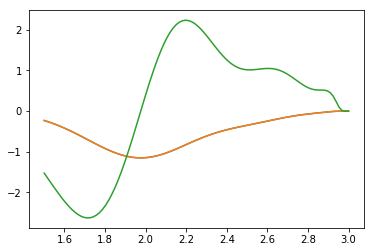

In [54]:
plt.plot(all_grids_2b[0], all_grids_2b[3])

mapped_2b = Spline1D(all_grids_2b[0],all_grids_2b[3])
plt.plot(all_grids_2b[0], mapped_2b(all_grids_2b[0], nu=0))
plt.plot(all_grids_2b[0], mapped_2b(all_grids_2b[0], nu=1))


In [55]:

traj = []

forces = np.zeros((ntest, 3))

for i in np.arange(ntest):

    coords = np.vstack([[0,0,0], tst_confs[i][:,:3]])
    atoms = Atoms('Fe' + str(len(coords)), positions=coords)

    atoms.set_cell([100,100,100])
    nl = FullNeighborList(rCut=4.45, atoms=atoms, driftfactor=0.)

    inds, pos, dists2 = nl.get_neighbors(0)

    dists = np.sqrt(dists2)
    energy_local = mapped_2b(dists, nu=0)
    fs_scalars = - mapped_2b(dists, nu=1)

    potential_energies = np.sum(energy_local, axis=0)
    forces[i] = np.sum(pos/dists[:, np.newaxis] * fs_scalars[:, np.newaxis], axis=0)
    
    print('test {}'.format(i))
    print(tst_forces[i])
    print(forces[i])
    print(gp_2b_forces[i])
    


test 0
[-0.396088  0.058324 -0.40305 ]
[-0.81701576  0.06283025 -0.31776974]
[-0.81701177  0.06283031 -0.31855326]
test 1
[ 0.514221 -0.783814  0.753292]
[ 0.11097376 -0.23111836  0.12284361]
[ 0.11362911 -0.23118302  0.12294929]


In [56]:
# ----------------------------------------
# Mapping 3b
# ----------------------------------------


mapping = SingleSpeciesGrid(gp_3, grid_start, r_cut, num_3b, elementslist[0], build2donly=False)
all_grids_3b = mapping.build_grids()

mapping = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}.npy'.format(3, ntr, sigma_3b, r_cut)

np.save(directory / mapping, all_grids_3b)
print('Saved mapping with name {}'.format(mapping))


Saved mapping with name MFF_3b_ntr_2_sig_0.60_cut_3.00.npy


In [57]:
mapped_3b = Spline3D(all_grids_3b[0],all_grids_3b[0],all_grids_3b[0],all_grids_3b[4])


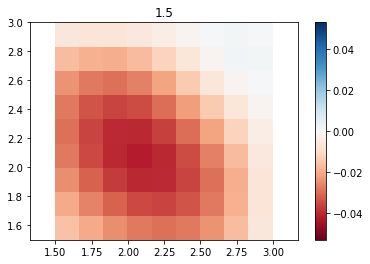

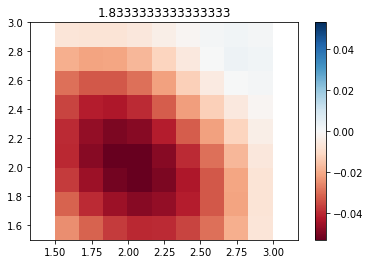

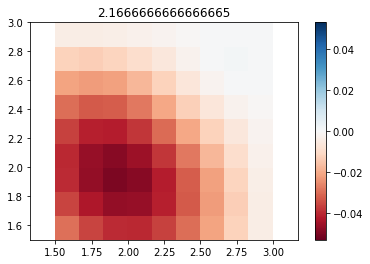

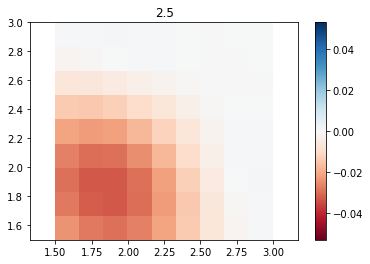

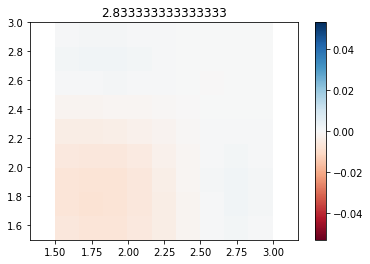

In [58]:
data = all_grids_3b[4]
dists = np.linspace(grid_start, r_cut, num_3b)
z_min, z_max = -np.max(np.abs(data)), np.max(np.abs(data))
for i in range(0, len(dists), 2):
    plt.title(dists[i])
    plt.pcolor(dists, dists, -data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

In [59]:
def find_triplets(atoms, nl):
    # atomic_numbers = self.atoms.get_array('numbers', copy=False)

    indices, distances, positions = [], [], dict()

    for i in range(len(atoms)):

        inds, pos, dists2 = nl.get_neighbors(i)

        # Limitation
        assert len(inds) is len(np.unique(inds)), "There are repetitive indices!\n{}".format(inds)

        # ignoring already visited atoms
        inds, pos, dists2 = inds[inds > i], pos[inds > i, :], dists2[inds > i]
        dists = np.sqrt(dists2)

        for local_ind, (j, pos_ij, dist_ij) in enumerate(zip(inds, pos, dists)):

            # Caching local displacement vectors
            positions[(i, j)], positions[(j, i)] = pos_ij, -pos_ij

            for k, dist_ik in islice(zip(inds, dists), local_ind + 1, None):

                try:
                    jk_ind = list(nl[j]).index(k)
                except ValueError:
                    continue  # no valid triplet

                _, _, dists_j = nl.get_neighbors(j)

                indices.append([i, j, k])
                distances.append([dist_ij, dist_ik, np.sqrt(dists_j[jk_ind])])

    return np.array(indices), np.array(distances), positions

# def find_triplets2(atoms, nl):
#     indices, distances, positions = [], [], dict()

#     # caching
#     arr = [nl.get_neighbors(i) for i in range(len(nl))]

#     for i, (inds, pos, dists2) in enumerate(arr):
#         # assert len(inds) is len(np.unique(inds)), "There are repetitive indices!\n{}".format(inds)

#         # ingnore already visited nodes
#         inds, pos, dists2 = inds[inds > i], pos[inds > i, :], dists2[inds > i]

#         dists = np.sqrt(dists2)
#         pos = pos / dists.reshape(-1, 1)

#         for (j_ind, j), (k_ind, k) in combinations(enumerate(inds), 2):

#             jk_ind, = np.where(arr[j][0] == k)

#             if not jk_ind.size:
#                 continue  # no valid triplet

#             indices.append([i, j, k])

#             # Caching local position vectors
#             dist_jk = np.sqrt(arr[j][2][jk_ind[0]])
#             positions[(i, j)], positions[(j, i)] = pos[j_ind], -pos[j_ind]
#             positions[(i, k)], positions[(k, i)] = pos[k_ind], -pos[k_ind]
#             positions[(j, k)], positions[(k, j)] = \
#                 arr[j][1][jk_ind[0], :] / dist_jk, -arr[j][1][jk_ind[0], :] / dist_jk

#             distances.append([dists[j_ind], dists[k_ind], dist_jk])

#     return np.array(indices), np.array(distances), positions

In [60]:
from itertools import combinations, islice

forces_2b = np.zeros((ntest, 3))
forces_3b = np.zeros((ntest, 3))

for i in np.arange(ntest):

    coords = np.vstack([[0,0,0], tst_confs[i][:,:3]])
    atoms = Atoms('Fe' + str(len(coords)), positions=coords)

    atoms.set_cell([100,100,100])
    nl = FullNeighborList(rCut=r_cut, atoms=atoms, driftfactor=0.)

    inds, pos, dists2 = nl.get_neighbors(0)

    dists = np.sqrt(dists2).reshape(-1, 1)
    norm = pos / dists

    energy_local = mapped_2b(dists, nu=0)
    fs_scalars = - mapped_2b(dists, nu=1)

    potential_energies = 1 / 2 * np.sum(energy_local, axis=0)
    forces_2b[i] = np.sum(norm * fs_scalars, axis=0)

    # 3 body    
    indices, distances, positions = find_triplets([atoms[0]], nl)

#     print(indices)
    
    xi, yi, zi = np.hsplit(distances, 3)
    mapped = mapped_3b.ev_all(zi, xi, yi)

    for (i, j, k), energy, dE_ij, dE_jk, dE_ki in zip(indices, mapped[0], mapped[1], mapped[2], mapped[3]):
        forces_3b[i] +=  positions[(i, j)] * dE_ij + positions[(i, k)] * dE_ki
        # forces_3b[j] += - positions[(j, k)] * dE_jk - positions[(j, i)] * dE_ij
        # forces_3b[k] += - positions[(k, i)] * dE_ki - positions[(k, j)] * dE_jk

        # potential_energies[[i, j, k]] += energy

    print('test {}'.format(i))
    print(forces_2b[i])
    print(gp_2b_forces[i])
    print(forces_3b[i])
    print(gp_3b_forces[i])
    print(tst_forces[i])



test 0
[-0.81701576  0.06283025 -0.31776974]
[-0.81701177  0.06283031 -0.31855326]
[-0.00662752 -0.00131296 -0.00487827]
[ 0.00562504 -0.0022672   0.00037585]
[-0.396088  0.058324 -0.40305 ]
test 0
[-0.81701576  0.06283025 -0.31776974]
[-0.81701177  0.06283031 -0.31855326]
[ 0.0039079  -0.01477247 -0.01381462]
[ 0.00562504 -0.0022672   0.00037585]
[-0.396088  0.058324 -0.40305 ]


In [61]:
i=0

coords = np.vstack([[0,0,0], tst_confs[i][:,:3]])
atoms = Atoms('Fe' + str(len(coords)), positions=coords)

atoms.set_cell([100,100,100])
nl = FullNeighborList(rCut=r_cut, atoms=atoms, driftfactor=0.)

inds, pos, dists2 = nl.get_neighbors(0)

dists = np.sqrt(dists2).reshape(-1, 1)
norm = pos / dists

energy_local = mapped_2b(dists, nu=0)
fs_scalars = - mapped_2b(dists, nu=1)

potential_energies = 1 / 2 * np.sum(energy_local, axis=0)
forces_2b[i] = np.sum(norm * fs_scalars, axis=0)

# 3 body    
indices, distances, positions = find_triplets([atoms[0]], nl)

#     print(indices)

xi, yi, zi = np.hsplit(distances, 3)
mapped = mapped_3b.ev_all(zi, xi, yi)

for (i, j, k), energy, dE_ij, dE_jk, dE_ki in zip(indices, mapped[0], mapped[1], mapped[2], mapped[3]):
    forces_3b[i] +=  positions[(i, j)] * dE_ij + positions[(i, k)] * dE_ki
    # forces_3b[j] += - positions[(j, k)] * dE_jk - positions[(j, i)] * dE_ij
    # forces_3b[k] += - positions[(k, i)] * dE_ki - positions[(k, j)] * dE_jk

    # potential_energies[[i, j, k]] += energy
forces_3b_gp_test = 0
for (i,j,k) in indices:
    
    conf = np.array([[
        [*positions[(i,j)], 26, 26],
        [*positions[(i,k)], 26, 26]
    ]])
#     print(conf)
    forces_3b_gp_test += gp_3.predict(conf)


print('test {}'.format(i))
print(forces_2b[i])
print(gp_2b_forces[i])
print(forces_3b[i])
print(gp_3b_forces[i])
print(forces_3b_gp_test)
print(tst_forces[i])

test 0
[-0.81701576  0.06283025 -0.31776974]
[-0.81701177  0.06283031 -0.31855326]
[-0.00271961 -0.01608543 -0.01869289]
[ 0.00562504 -0.0022672   0.00037585]
[[ 0.00562504 -0.0022672   0.00037585]]
[-0.396088  0.058324 -0.40305 ]


## ASE Calculator

In [62]:

def rmse(x1, x2):
    rms = np.sqrt(np.sum(np.square(x1 - x2), axis=1))
    return np.mean(rms), np.std(rms)
    

In [63]:
# grid_2b = TwoBodySingleSpeciesGrid.from_file(str(directory / 'MFF_2b_ntr_20_sig_0.30_cut_4.45.npy'))
# grid_3b = ThreeBodySingleSpeciesGrid.from_file(str(directory / 'MFF_3b_ntr_20_sig_0.60_cut_4.45.npy'))

# calc = ThreeBodySingleSpecies(r_cut=4.45, grid_2b=grid_2b, grid_3b=grid_3b)


# filename = directory / 'movie.xyz'
# traj = read(str(filename), index=slice(0,5))
# for atoms in traj[0:5]:

#     atoms.set_calculator(calc)

#     rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
#     print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))



In [64]:

rs, element1, _, grid_1_1_data, _ = np.load(directory / 'MFF_2b_ntr_20_sig_0.30_cut_4.45.npy')
grid_2b = Spline1D(rs, grid_1_1_data)

# calc = TwoBodySingleSpecies(r_cut=4.45, grid_2b=grid_2b)

rs, element1, _, _, grid_1_1_1_data = np.load(directory / 'MFF_3b_ntr_20_sig_0.60_cut_4.45.npy')
grid_3b = Spline3D(rs, rs, rs, grid_1_1_1_data)

calc = ThreeBodySingleSpecies(r_cut=4.45, grid_2b=grid_2b, grid_3b=grid_3b)


filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0,5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))




INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 1.1714 +- 0.4670
MAEF on forces: 1.1753 +- 0.4562
MAEF on forces: 1.1756 +- 0.4556
MAEF on forces: 1.1772 +- 0.4605
MAEF on forces: 1.1765 +- 0.4707
